In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Rectangle
import numpy as np
import os
from matplotlib.ticker import AutoMinorLocator, LogLocator, NullFormatter

In [2]:
markers = ['o', 's', '+', '^', '.', '*']
LEGEND_SIZE=15
LABEL_SIZE=18
TICK_SIZE=15
FIG_W_SIZE=6
FIG_H_SIZE=3
META_WIDTH = 5
y_minor = LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
META_YLIM=(1,2000000)
META_WIDTH = 5

In [ ]:
DATA_DIR="data/"

In [3]:
# 1s internal timeout, 5 max_retries
df = pd.read_csv(DATA_DIR + "meta3_hotel_blueprint_24000.csv")
start_time = np.min(df['Start'])
df['start_rel'] = (df.Start - start_time) / 1e9
df['start_rel'] = df['start_rel'].astype(int)
df.Duration = df.Duration / 1e6

In [4]:
anomaly_file = open(DATA_DIR + 'meta3_24000_ts.txt')
trigger_start_ns = int(anomaly_file.read())
anomaly_file.close()
trigger_start_rel = (trigger_start_ns - start_time) / 1e9
trigger_end_rel = trigger_start_rel + 30

In [5]:
def q99(x):
    return x.quantile(0.99)

filtered_df = df.groupby(df['start_rel']).agg(start_rel=('start_rel', 'mean'), avg_lat=('Duration','mean'), p99_lat=('Duration',q99))

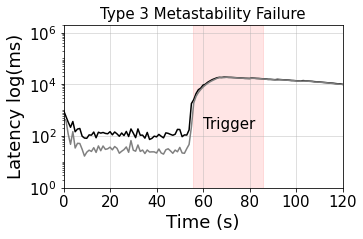

In [6]:
fig,ax = plt.subplots(figsize=(META_WIDTH,FIG_H_SIZE))
ax.plot(filtered_df['start_rel'], filtered_df.p99_lat, color="black", label='99th Percentile')
ax.plot(filtered_df['start_rel'], filtered_df.avg_lat, color='gray', label='Average')
ax.set_ylim(*META_YLIM)
ax.set_yscale('log')
ax.set_xlabel('Time (s)', fontsize=LABEL_SIZE)

ax.grid(visible=True, which='major', axis='both', alpha=0.5)

ax.yaxis.set_minor_locator(y_minor)
ax.yaxis.set_minor_formatter(NullFormatter())
ax.set_ylabel('Latency log(ms)', fontsize=LABEL_SIZE)
ax.axvspan(trigger_start_rel, trigger_start_rel+30, color="red", alpha=0.1)
ax.text(60, 200, "Trigger", fontsize=LEGEND_SIZE)
ax.tick_params(labelsize=TICK_SIZE)
plt.margins(x=0,y=0)
plt.title('Type 3 Metastability Failure', fontsize=LEGEND_SIZE)
fig.savefig('meta3.png', bbox_inches='tight', dpi=1200)
plt.show()